# Попытка 3

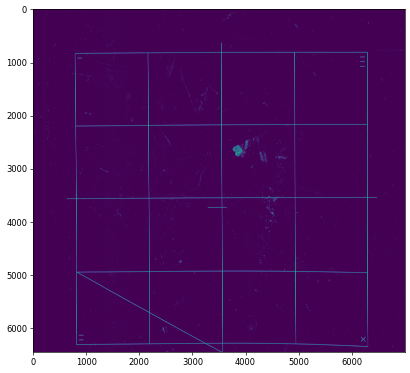

In [17]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt


PATH_TO_INPUT_IMAGES = 'images/examples/'

IMAGE_NAME = '25.tif'
# IMAGE_NAME = '26.tif'


IMAGE_PATH = PATH_TO_INPUT_IMAGES + IMAGE_NAME

img = cv2.imread(IMAGE_PATH)[3050:9500, 1000:8000]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.uint8(gray)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=gray)
plt.show()

In [18]:
kernel_size = 7

blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0) 

# plt.figure(figsize=(32, 32), dpi=60)
# plt.imshow(X=blur_gray)
# plt.show()
# cv2.imwrite('blur_gray.png', blur_gray)

In [19]:
low_threshold = 140
high_threshold = 310

without_noise = cv2.Canny(blur_gray, low_threshold, high_threshold)

# plt.figure(figsize=(32, 32), dpi=60)
# plt.imshow(X=without_noise)
# plt.show()

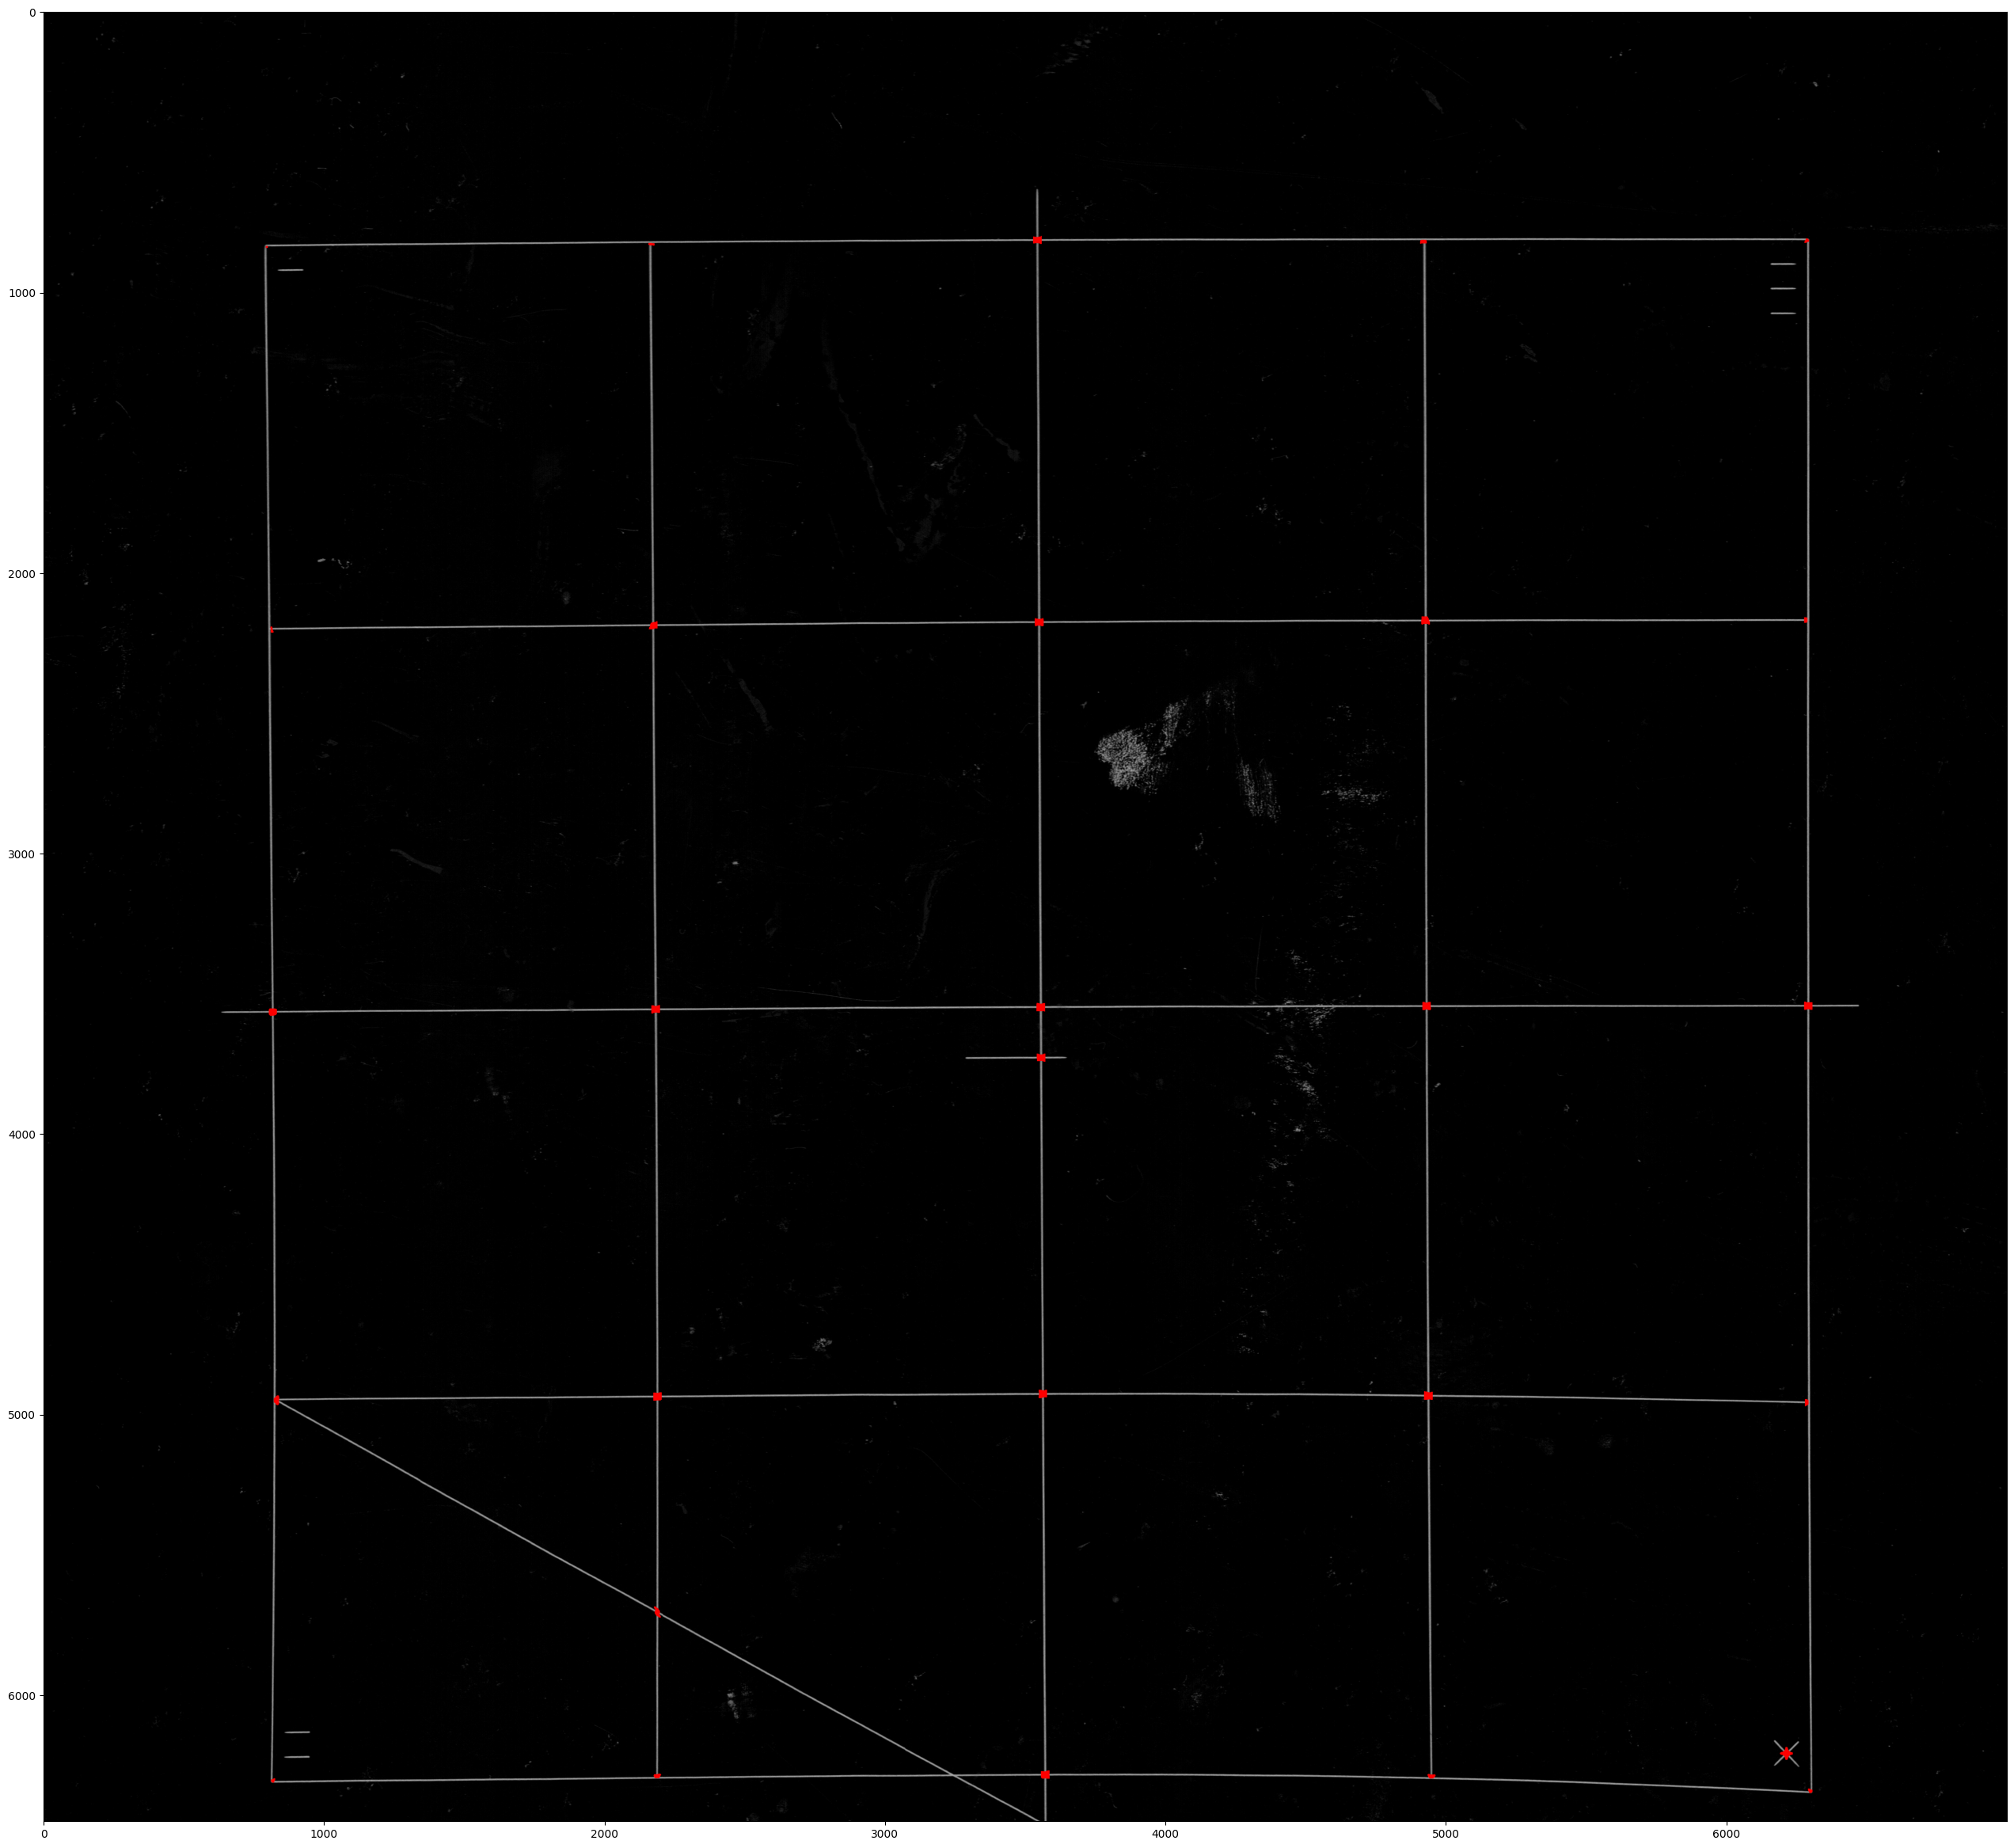

In [20]:
without_noise = np.float32(without_noise)

# dst = cv2.cornerHarris(without_noise, 25, 31, 0.12)
dst = cv2.cornerHarris(without_noise, 25, 15, 0.17)
dst = cv2.dilate(dst, None)

# img = cv2.imread(IMAGE_PATH)[3050:9500, 1000:8000]
img = cv2.imread(IMAGE_PATH)[3050:9500, 1000:8000]
img[dst > 0.12 * dst.max()] = [255, 0, 0]

plt.figure(figsize=(32, 32), dpi=100)
plt.imshow(X=img)
plt.show()

In [21]:
colored_dots = (dst > 0.12 * dst.max()).nonzero()

In [22]:
len(colored_dots[0])

15669

In [23]:
# Считаем расстояние между яркими точками

horisontal_values_matrix = (colored_dots[0] - colored_dots[0][:,np.newaxis]) ** 2  # (x_0 - x_1) ** 2
vertical_values_matrix = (colored_dots[1] - colored_dots[1][:,np.newaxis]) ** 2  # (y_0 - y_1) ** 2
distance_between_dots = np.sqrt(horisontal_values_matrix + vertical_values_matrix)


# Для того, что бы не было повторов, нижний треугольник заполняем большими значениями начиная с диагонали

distance_without_bottom_triangle = distance_between_dots + np.tri(*distance_between_dots.shape) * 100

In [24]:
# Получаем пары близких друг к другу вершин

MAX_DISTANCE_BETWEEN_PIXELS = 30
closest_pixels = np.argwhere(distance_without_bottom_triangle < MAX_DISTANCE_BETWEEN_PIXELS)
len(closest_pixels)

5408397

In [25]:
# Собираем кластеры

from typing import Set, List, Tuple

from pydantic import BaseModel

class Cluster(BaseModel):
    pixels_in_cluster: Set[int]
    close_pixels: List[Tuple[int, int]]

clusters: List[Cluster] = []

for pixels_pair in closest_pixels:
    was_inserted = False
    for existing_cluster in clusters:
        if pixels_pair[0] in existing_cluster.pixels_in_cluster:
            existing_cluster.pixels_in_cluster.update([pixels_pair[1]])
            existing_cluster.close_pixels.append(pixels_pair)
            was_inserted = True
            break
    if not was_inserted:
#         clusters.append([set((pixels_pair[0], pixels_pair[1])), [pixels_pair]])
        clusters.append(Cluster(
            pixels_in_cluster=set((pixels_pair[0], pixels_pair[1])),
            close_pixels=[tuple(pixels_pair)]
        ))

print(f'Было найдено: {len(clusters)} кластеров')

Было найдено: 28 кластеров


In [26]:
colored_dots

(array([ 801,  801,  801, ..., 6349, 6349, 6349]),
 array([3556, 3557, 3558, ..., 6299, 6300, 6301]))

In [27]:
# Восстанавливаем координаты точек кластера

clusters_coordinates: List[List[np.array]] = []

for cluster in clusters:
    cluster_coordinates: List[np.array] = []
    
    for point_in_cluster in cluster.pixels_in_cluster:
        cluster_coordinates.append([colored_dots[0][point_in_cluster], colored_dots[1][point_in_cluster]])
    
    clusters_coordinates.append(cluster_coordinates)

/var/folders/sf/k5vlnwf97ybb4_v12_1p98gw0000gn/T/ipykernel_12796/4090689117.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', len(clusters))


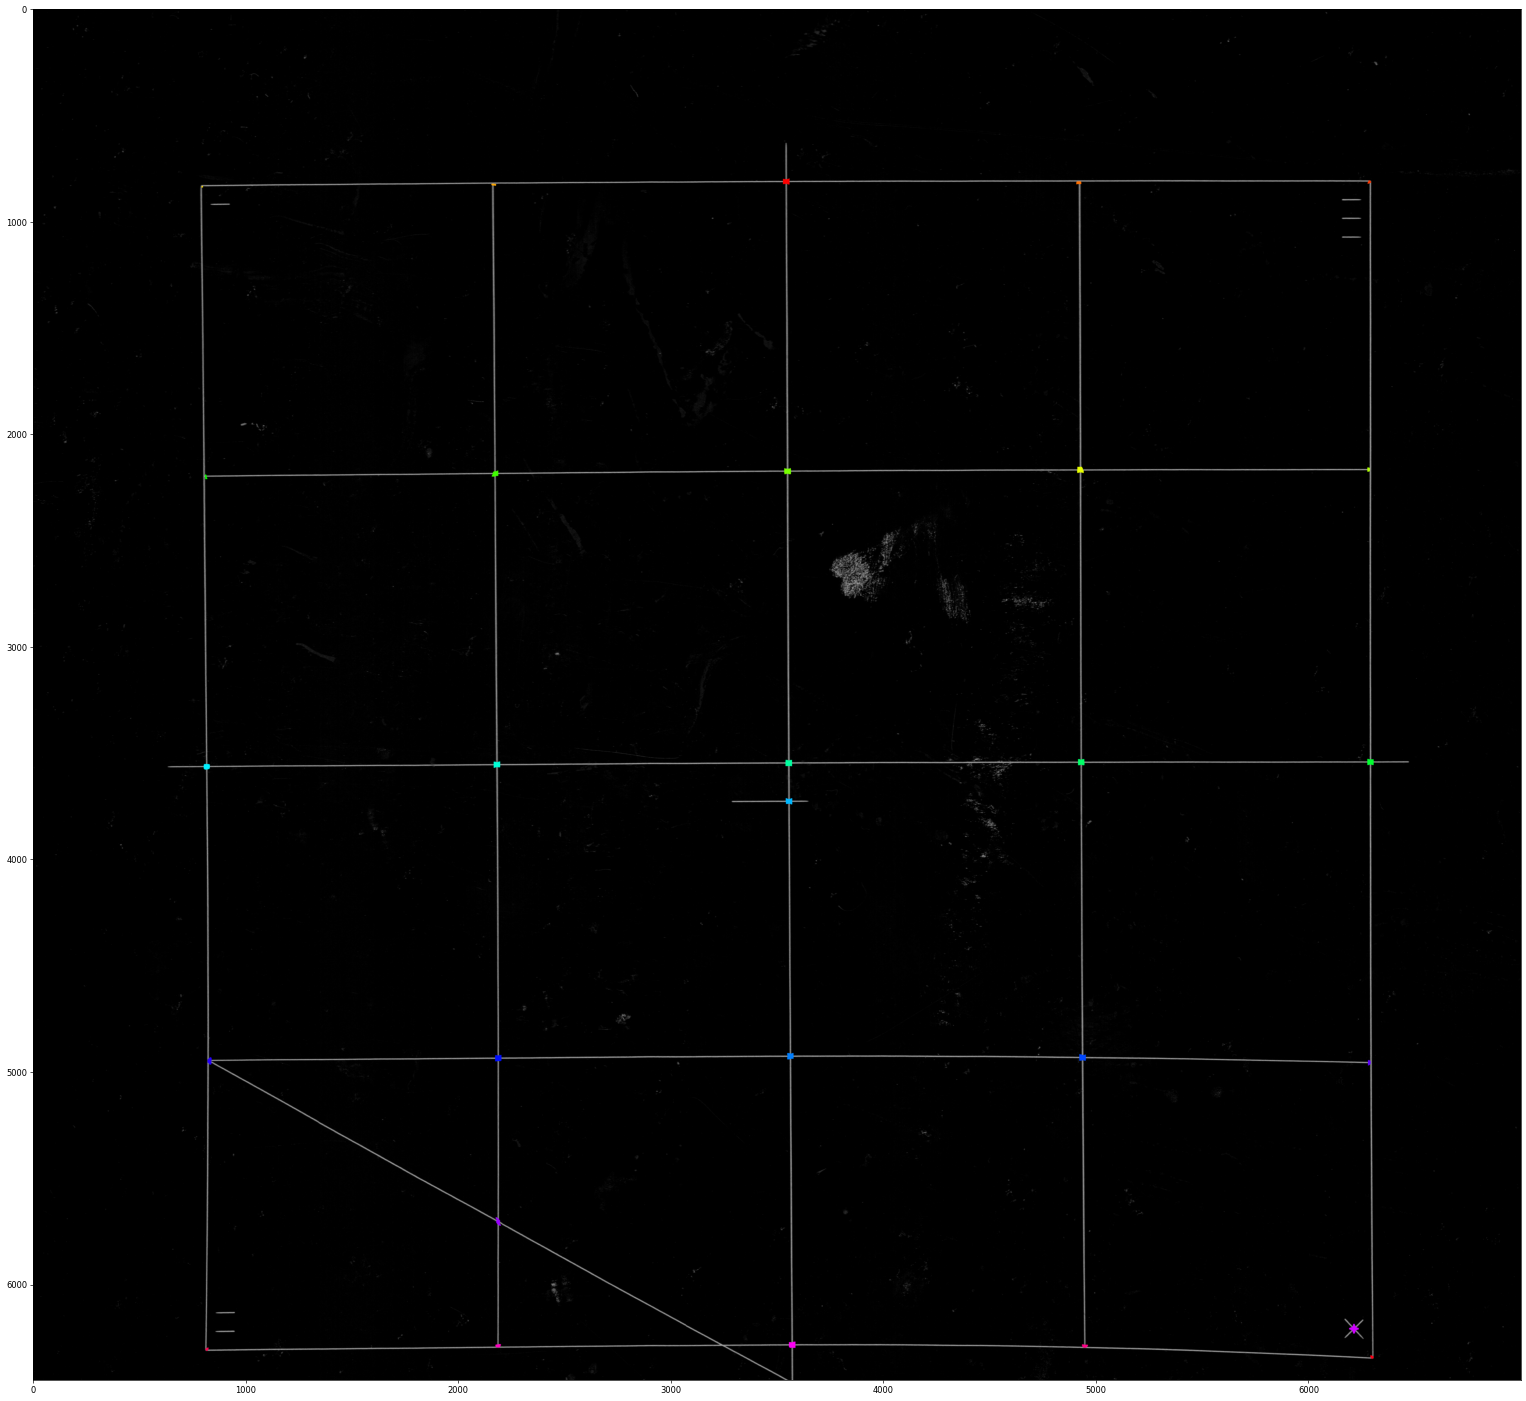

In [28]:
# Рисуем кластеры
img = cv2.imread(IMAGE_PATH)[3050:9500, 1000:8000]

result = img.copy()
# result = img.copy() * 0

cmap = plt.cm.get_cmap('hsv', len(clusters))
for number, cluster_coordinates in enumerate(clusters_coordinates):
    color = cmap(number)
    cluser_color = [255 * color[0], 255 * color[1], 255 * color[2]]

    for cluster_coordinate in cluster_coordinates:
        result[cluster_coordinate[0], cluster_coordinate[1]] = cluser_color

plt.figure(figsize=(32, 32), dpi=60)
plt.imshow(X=result)
plt.show()

# cv2.imwrite('clusters_on_lines_26.png', result)
# cv2.imwrite('clusters_black.png', result)

In [29]:
sorted_by_x = sorted(
    [
        np.mean(clusters_coordinates[cluster_n], axis=0)
        for cluster_n in range(len(clusters_coordinates))
    ], key=lambda x: x[1])
sorted_by_x

[array([839.96226415, 795.64150943]),
 array([2204.46857143,  813.32571429]),
 array([3566.25248227,  816.76028369]),
 array([6304.67664671,  818.19760479]),
 array([4949.72030651,  831.15517241]),
 array([ 830.18817204, 2167.24731183]),
 array([2189.48353293, 2174.80838323]),
 array([3556.4026764 , 2181.81873479]),
 array([6288.45373134, 2187.87164179]),
 array([5704.80755396, 2187.97122302]),
 array([4936.60095012, 2188.40380048]),
 array([ 815.35286285, 3543.43275632]),
 array([2177.37439614, 3549.57971014]),
 array([3549.36889898, 3555.02497162]),
 array([3728.75158428, 3556.37262357]),
 array([4927.04674047, 3562.29766298]),
 array([6284.37394451, 3571.44270205]),
 array([ 821.31879195, 4919.33557047]),
 array([2171.28552803, 4925.88265971]),
 array([3545.07701564, 4930.61853189]),
 array([4933.8337156 , 4936.69610092]),
 array([6289.39655172, 4947.84195402]),
 array([6208.60548523, 6213.81329114]),
 array([2169.5       , 6282.27192982]),
 array([4957.65034965, 6285.40909091]),
 a

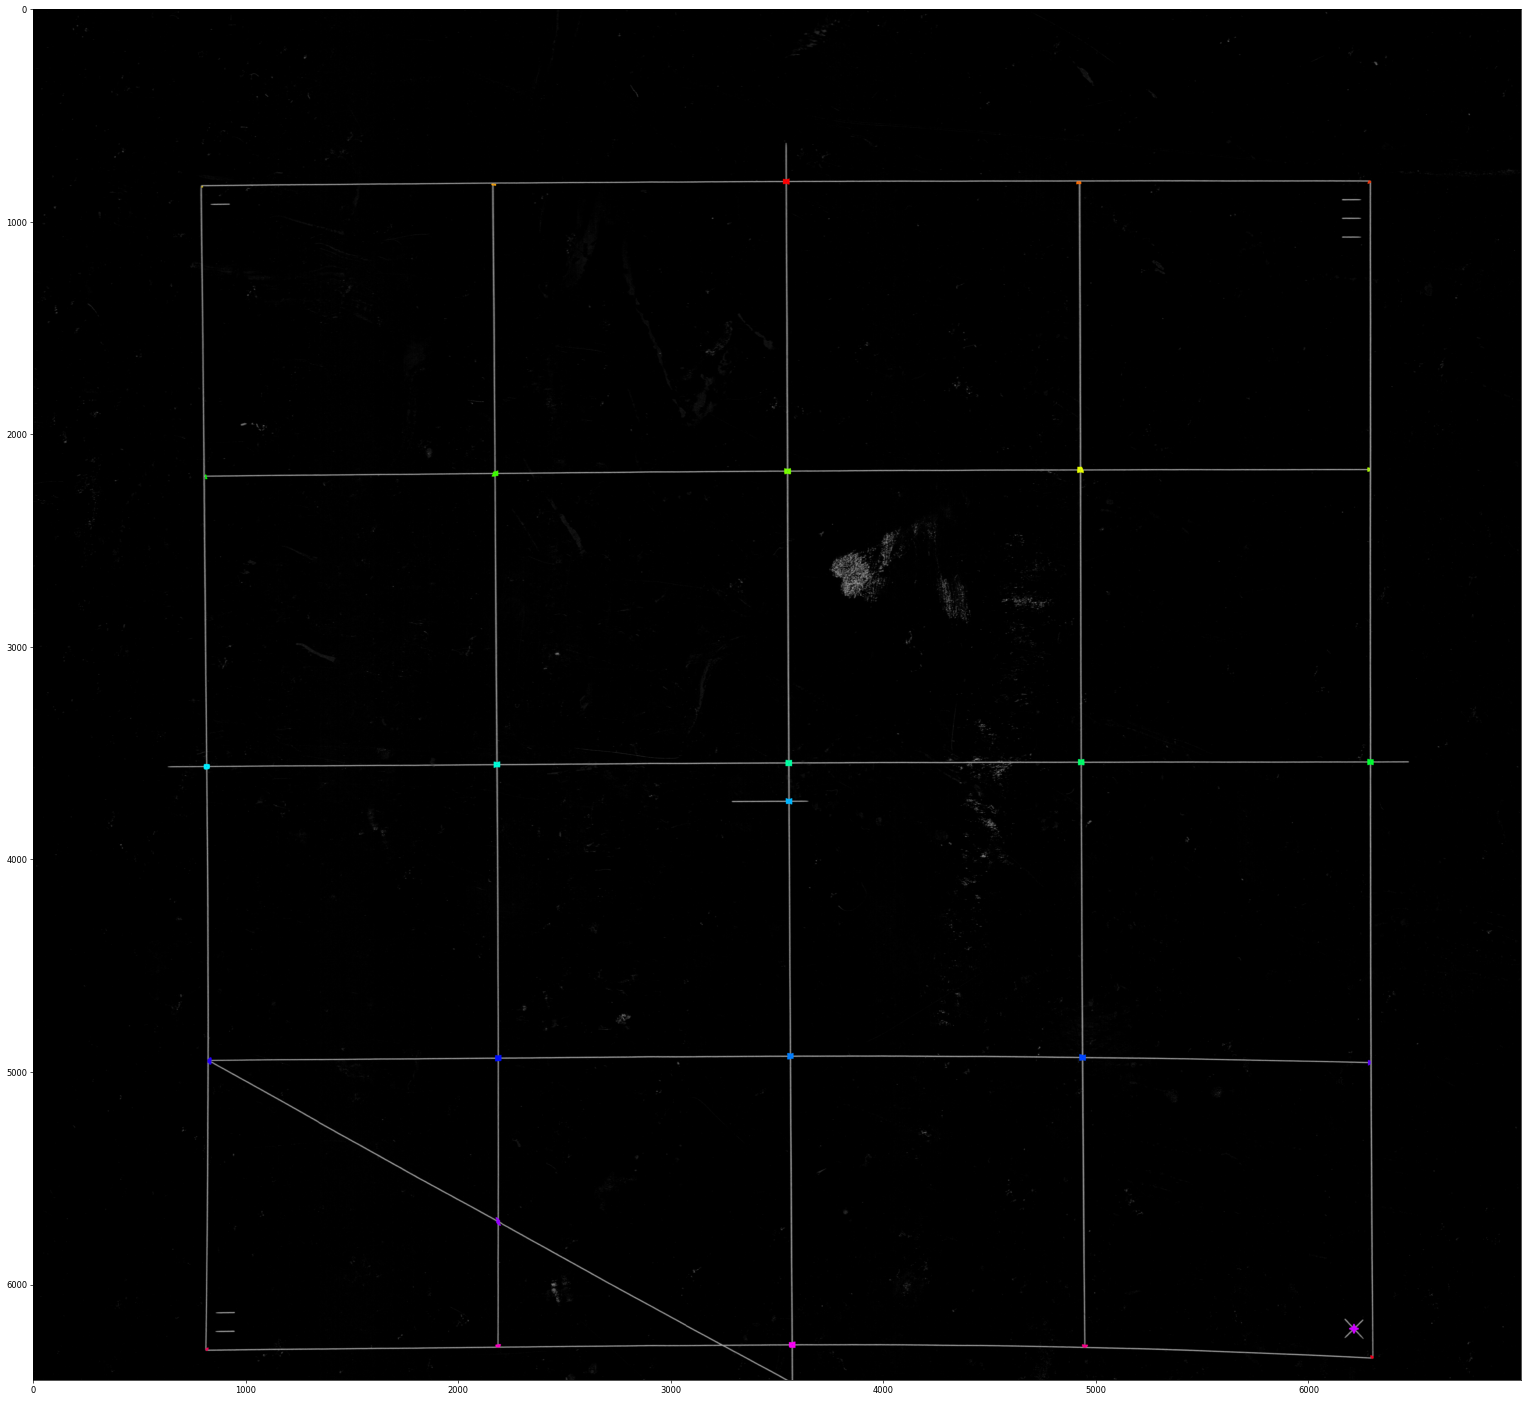

True

In [30]:
cross_color = [0, 0, 255]
for cluster_coordinates in clusters_coordinates:
    cluster_center = np.mean(cluster_coordinates, axis=0)
    cluster_center = [round(cluster_center[0]), round(cluster_center[1])]
    result[cluster_center[0], cluster_center[1]] = cross_color
    result[cluster_center[0], cluster_center[1]] = cross_color
    result[cluster_center[0]+1, cluster_center[1]+1] = cross_color
    result[cluster_center[0]-1, cluster_center[1]+1] = cross_color
    result[cluster_center[0]+1, cluster_center[1]-1] = cross_color
    result[cluster_center[0]-1, cluster_center[1]-1] = cross_color

plt.figure(figsize=(32, 32), dpi=60)
plt.imshow(X=result)
plt.show()

cv2.imwrite('clusters_with_centers.png', result)

In [2]:
# sorted_by_x = sorted(
#     [
#         np.mean(clusters_coordinates[cluster_n], axis=0)
#         for cluster_n in range(len(clusters_coordinates))
#     ], key=lambda x: x[1])
# sorted_by_x

In [3]:
# sorted_by_x = sorted(
#     [
#         np.mean(clusters_coordinates[cluster_n], axis=0)
#         for cluster_n in range(len(clusters_coordinates))
#     ], key=lambda x: x[0])
# sorted_by_x

In [ ]:
def fix_corners():
    pass

def fix_centers():
    pass

def fix_borders():
    pass


# Поиск центров перекрестий №1

1. Кластарезуем светлые пиксели по расстоянию друг от друга
2. Расчитываем центры конечностей ребер, составляющих кресты
3. Определеяем центры крестов, как пересечение двух линий, образованных найденными центрами ребер

## Шаг 1: поиск кластеров крестов

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from random import randint

from pydantic import BaseModel

ModuleNotFoundError: No module named 'cv2'

In [171]:
# Дефим константы и всю хуйню

def convert_pixels_to_cm(pixels):
    return pixels / 2.54

PATH_TO_INPUT_IMAGES = 'images/examples'
IMAGE_NAME = 'example_crosses.jpg'
# IMAGE_NAME = 'example_upscale.jpg'

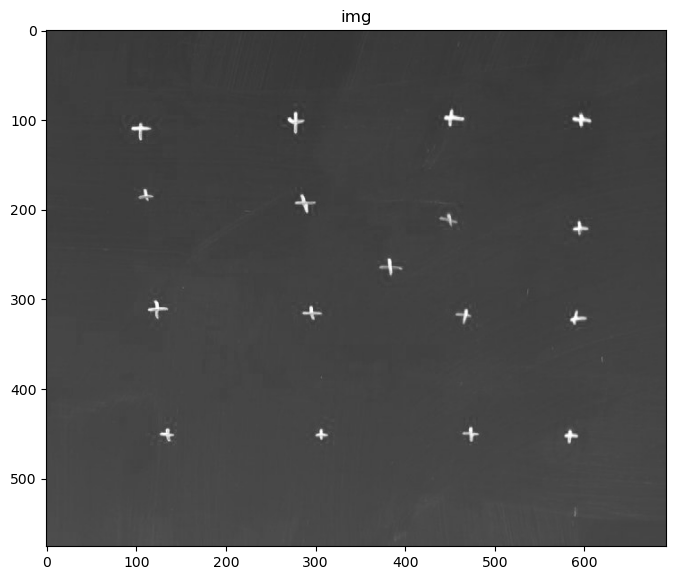

In [172]:
# Открываем изображение

img = cv2.imread(filename=f'{PATH_TO_INPUT_IMAGES}/{IMAGE_NAME}')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(X=img)
plt.title(f'img')
plt.show()

In [173]:
# Получаем координаты светлых точек

MINIMUM_BRIGHTNESS = 150
light_pixels = np.argwhere(gray[:,:] > MINIMUM_BRIGHTNESS)
len(light_pixels)

1653

In [174]:
# Я бы дополнительно нарисовал найденные точки тут
# light_pixels

In [175]:
# Тупо что б не забыть, в каком порядке что идет

UPPER_BORDER_PIXEL = min(light_pixels[:,0])
LOWER_BORDER_PIXEL = max(light_pixels[:,0])

RIGHTES_BORDER_PIXEL = max(light_pixels[:,1])
LEFTES_BORDER_PIXEL = min(light_pixels[:,1])

LEFTES_BORDER_PIXEL, RIGHTES_BORDER_PIXEL, LOWER_BORDER_PIXEL, UPPER_BORDER_PIXEL

(95, 607, 461, 90)

In [176]:
# Считаем расстояние между яркими точками

horisontal_values_matrix = (light_pixels[:,0] - light_pixels[:,0][:,np.newaxis]) ** 2  # (x_0 - x_1) ** 2
vertical_values_matrix = (light_pixels[:,1] - light_pixels[:,1][:,np.newaxis]) ** 2  # (y_0 - y_1) ** 2
distance_between_dots = np.sqrt(horisontal_values_matrix + vertical_values_matrix)


# Для того, что бы не было повторов, нижний треугольник заполняем большими значениями начиная с диагонали

distance_without_bottom_triangle = distance_between_dots + np.tri(*distance_between_dots.shape) * 100

In [177]:
# Получаем пары близких друг к другу вершин

MAX_DISTANCE_BETWEEN_PIXELS = 16
closest_pixels = np.argwhere(distance_without_bottom_triangle < MAX_DISTANCE_BETWEEN_PIXELS)
len(closest_pixels)

83795

In [178]:
# Собираем кластеры

from typing import Set, List, Tuple

class Cluster(BaseModel):
    pixels_in_cluster: Set[int]
    close_pixels: List[Tuple[int, int]]

clusters: List[Cluster] = []

for pixels_pair in closest_pixels:
    was_inserted = False
    for existing_cluster in clusters:
        if pixels_pair[0] in existing_cluster.pixels_in_cluster:
            existing_cluster.pixels_in_cluster.update([pixels_pair[1]])
            existing_cluster.close_pixels.append(pixels_pair)
            was_inserted = True
            break
    if not was_inserted:
#         clusters.append([set((pixels_pair[0], pixels_pair[1])), [pixels_pair]])
        clusters.append(Cluster(
            pixels_in_cluster=set((pixels_pair[0], pixels_pair[1])),
            close_pixels=[tuple(pixels_pair)]
        ))

print(f'Было найдено: {len(clusters)} кластеров')

Было найдено: 17 кластеров


In [179]:
light_pixels

array([[ 90, 452],
       [ 90, 453],
       [ 91, 451],
       ...,
       [460, 584],
       [460, 585],
       [461, 584]])

In [ ]:
# Восстанавливаем координаты точек кластера

clusters_coordinates: List[List[np.array]] = []

for cluster in clusters:
    cluster_coordinates: List[np.array] = []
    for point_in_cluster in cluster.pixels_in_cluster:
        cluster_coordinates.append(light_pixels[point_in_cluster])
    clusters_coordinates.append(cluster_coordinates)

In [ ]:
# Рисуем кластеры

result = img.copy()

for cluster_coordinates in clusters_coordinates:
#     cluser_color = [randint(100, 255), randint(100, 255), randint(100, 255)]
    cluser_color = [255, 0, 0]
    for cluster_coordinate in cluster_coordinates:
        result[cluster_coordinate[0], cluster_coordinate[1]] = cluser_color

plt.figure(figsize=(32, 32), dpi=60)
plt.imshow(X=result)
plt.title(f'img {len(img)}')
plt.show()

## Шаг 2: поиск центров крестов

In [ ]:
# Возьмем для начала крайние точки крестов и будем считать от них
        
def line(BaseModel):
    slope: float
    zero_point: float


centers_of_crosses = []

for cluster_coordinates in clusters_coordinates:
    cluster_row = np.array(cluster_coordinates)[:,1]
    lower_x_point = cluster_coordinates[np.argmin(cluster_row)]
    upper_x_point = cluster_coordinates[np.argmax(cluster_row)]
    x_points_delta = upper_x_point - lower_x_point

    horisonal_line_slope = x_points_delta[0] / x_points_delta[1]
    horisonal_line_shift = lower_x_point[0] - horisonal_line_slope * lower_x_point[1]
    
#     horisonal_y = horisonal_line_slope * horisonal_x - horisonal_line_shift
#     horisonal_y - horisonal_line_slope * horisonal_x + horisonal_line_shift = 0
    
    
    cluster_column = np.array(cluster_coordinates)[:,0]
    lower_y_point = cluster_coordinates[np.argmin(cluster_column)]
    upper_y_point = cluster_coordinates[np.argmax(cluster_column)]
    y_points_delta = upper_y_point - lower_y_point
    if y_points_delta[1] == 0:
        # Линия полностью вертикальна
        # Переделать алгоритм для корректного расчета. Наверно
        vertical_line_slope = 99999999
    else:
        vertical_line_slope = y_points_delta[0] / y_points_delta[1]
    vertical_line_shift = lower_y_point[0] - vertical_line_slope * lower_y_point[1]
    
#     horisonal_y = vertical_line_slope * vertical_y - vertical_line_shift
#     horisonal_y - vertical_line_slope * vertical_x + vertical_line_shift = 0
    
    
    x_center = (horisonal_line_shift - vertical_line_shift) / (vertical_line_slope - horisonal_line_slope)
    y_center = horisonal_line_slope * x_center + horisonal_line_shift
    
    centers_of_crosses.append([round(y_center), round(x_center)])

#     print(lower_x_point, upper_x_point, horisonal_line_slope, horisonal_line_shift, x_center)
#     print(lower_y_point, upper_y_point, vertical_line_slope, vertical_line_shift, y_center)
    
#     print()


In [ ]:
centers_of_crosses

In [ ]:
# Рисуем кластеры

for center_of_cross in centers_of_crosses:
#     cluser_color = [randint(100, 255), randint(100, 255), randint(100, 255)]
    cluser_color = [0, 0, 255]
    result[center_of_cross[0], center_of_cross[1]] = cluser_color
    result[center_of_cross[0]+1, center_of_cross[1]+1] = cluser_color
    result[center_of_cross[0]-1, center_of_cross[1]+1] = cluser_color
    result[center_of_cross[0]+1, center_of_cross[1]-1] = cluser_color
    result[center_of_cross[0]-1, center_of_cross[1]-1] = cluser_color

plt.figure(figsize=(32, 32), dpi=60)
plt.imshow(X=result)
plt.title(f'img {len(img)}')
plt.show()

## Шаг 3: упорядочивание крестов

## Шаг 4: рассчет расстояния между крестами

# Поиск центров перекрестий №2

1. Поиск пересечения линий

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from random import randint

import isect_segments_bentley_ottmann.poly_point_isect as bot

from pydantic import BaseModel

In [2]:
PATH_TO_INPUT_IMAGES = 'images/examples'

Text(0.5, 1.0, 'img 6450')

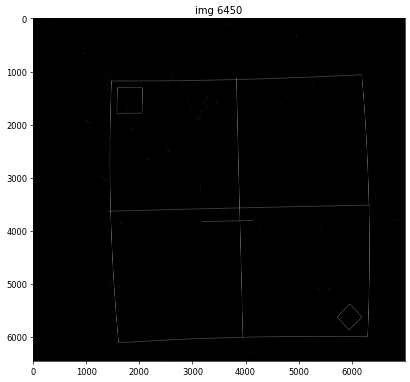

In [3]:
# img = cv2.imread(f'{PATH_TO_INPUT_IMAGES}/example.jpg')
# img = cv2.imread(f'{PATH_TO_INPUT_IMAGES}/sDQLM.png')
# img = cv2.imread(f'{PATH_TO_INPUT_IMAGES}/example_upscale.jpg')
# img = cv2.imread(f'{PATH_TO_INPUT_IMAGES}/25.tif')[3050:9500, 1000:8000]
img = cv2.imread(f'{PATH_TO_INPUT_IMAGES}/26.tif')[3050:9500, 1000:8000]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=img)
plt.title(f'img {len(img)}')
# plt.show()

In [4]:
kernel_size = 9

# blur_gray = cv2.blur(gray, (kernel_size, kernel_size), 0) * 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0) 

# plt.figure(figsize=(32, 32), dpi=600)
# plt.imshow(X=blur_gray)
# plt.show()
# cv2.imwrite('blur_gray.png', blur_gray)

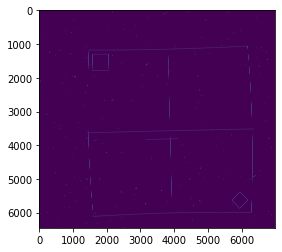

In [5]:
low_threshold = 10
high_threshold = 60

edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=edges)
plt.show()

# cv2.imwrite('canny.png', edges)

In [6]:
def generate_points(rho, theta, threshold, min_line_length, max_line_gap):
    print(f'rho: {rho}, theta: {theta}, threshold: {threshold}, '
          f'min_line_length: {min_line_length}, max_line_gap: {max_line_gap}')
    theta = np.pi / theta
    line_image = np.copy(img) * 0  # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    points = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            points.append(((x1, y1), (x2, y2)))
            cv2.line(img=line_image, pt1=(x1, y1), pt2=(x2, y2), color=(255, 0, 0), thickness=1)
    return points

#     plt.figure(figsize=(8, 8), dpi=120)
#     plt.imshow(X=line_image)
#     plt.show()

def generate_lines(img, line_image):
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
    cv2.imwrite('line_parking.png', lines_edges)

#     plt.figure(figsize=(8, 8), dpi=60)
#     plt.imshow(X=lines_edges)
#     plt.show()
    return lines_edges

def plot_square(points, lines_edges, dpi =  120):
    intersections = bot.isect_segments(points)
    for inter in intersections:
        a, b = inter
        for i in range(3):
            for j in range(3):
                lines_edges[int(b) + i, int(a) + j] = [0, 255, 0]

    cv2.imwrite('result.png', lines_edges)
#     plt.figure(figsize=(32, 32), dpi=800)
#     plt.imshow(X=lines_edges)
#     plt.show()

In [7]:
### rho, theta, threshold, min_line_length, max_line_gap

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# for theta in range(10, 180*2, 10):
# for threshold in range(0, 40, 5): 
# for min_line_length in range(1, 40, 3):        
# for max_line_gap in range(1, 40, 3):

# points = generate_points(1, 180, 60, 50, 40)
# points = points + generate_points(1, 180, 40, 10, 40)
# points = points + generate_points(1, 180, 40, 10, 40)\
# points = generate_points(rho=1, theta=180, threshold=40, min_line_length=40, max_line_gap=40)
# points = generate_points(1, 90, 60, 10, 10) # + points 
# points = generate_points(2, 90, 60, 10, 10) # + points 
# points = points + generate_points(3, 180, 300, 10, 40)


# lines = generate_lines(img, line_image)
# plot_square(set(points), lines)

In [196]:
lines

array([[[1601, 6449, 1601,    0]],

       [[1393,    0, 1506, 6447]],

       [[ 597, 3549, 6739, 3549]],

       ...,

       [[ 523, 2683,  535, 2578]],

       [[2953, 1850, 2953, 1594]],

       [[6107, 1228, 6109, 1218]]], dtype=int32)

rho: 1, theta: 0.017453292519943295, threshold: 15, min_line_length: 50, max_line_gap: 20


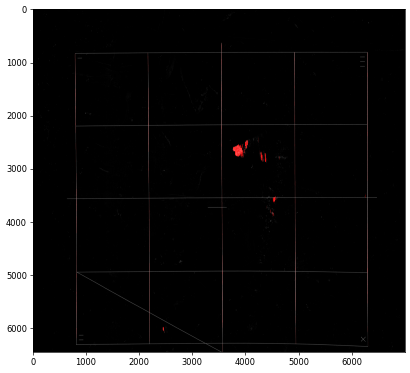

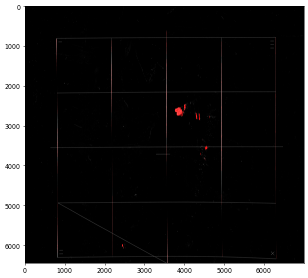

In [197]:
print(f'rho: {rho}, theta: {theta}, threshold: {threshold}, '
      f'min_line_length: {min_line_length}, max_line_gap: {max_line_gap}')
theta = np.pi / theta
line_image = np.copy(img) * 0  # creating a blank to draw lines on
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
points = []
for line in lines:
    for x1, y1, x2, y2 in line:
        points.append(((x1, y1), (x2, y2)))
        cv2.line(img=line_image, pt1=(x1, y1), pt2=(x2, y2), color=(255, 0, 0), thickness=1)


# plt.figure(figsize=(8, 8), dpi=120)
# plt.imshow(X=line_image)
# plt.show()


lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
#cv2.imwrite('line_parking.png', lines_edges)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=lines_edges)
plt.show()

intersections = bot.isect_segments(points)
for inter in intersections:
    a, b = inter
    for i in range(3):
        for j in range(3):
            lines_edges[int(b) + i, int(a) + j] = [0, 255, 0]

plt.figure(figsize=(8, 8), dpi=45)
plt.imshow(X=lines_edges)

plt.show()

In [ ]:
(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)